In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys
import re
import logging
import os
import re
from pathlib import Path
from functools import partial, cache, cached_property
from itertools import chain
from uuid import uuid4

import blpapi
import ipywidgets as w
import ipyvuetify as v
import numpy as np
import pandas as pd
import QuantLib as ql
from IPython.display import display
from ipydatagrid import DataGrid, TextRenderer, BarRenderer, Expr, VegaExpr
from bqplot import LinearScale, ColorScale, OrdinalColorScale, OrdinalScale
from pandas.tseries.offsets import BDay
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
# from bhsysapi import BHSysApi

from api.data.base import data_path, radar_path
from api.history_plotter_v2 import ExpressionHandler
from api.gui.params import bbg_params, spot_params, fwd_params
from api.instruments.swap import RealSwap, RollingSwap, Fly, Spread
from api.instruments.utils import parse_dates, parse_number, ez_bump
from api.instruments.future import FutureChain, FutureSpread, FutureFly, FutureStructure
from api.gui.theme import bg_color, grid_style
from api.gui.pandas import DFOutput, negative_red, custom_styler_row_line, DataGridGio

from gioutils import ezutils as ez
from gioutils.ezutils import bh, bhs
from gioutils.blpw import BlpQuery
from gioutils.gui.pandas import millify
from gioutils.utils import (
    RepeatedTimer, 
    read_history_plotter_ts,
    parse_swap_tenor_expr, 
    parse_offset,
    today, 
    get_next_n, 
    get_n_from_code,
    date_from_offset, 
    get_bday,
    get_bbg_fut_chain_ticker,
    get_df_reg,
)

from techi import api as ti

In [3]:
pd.options.plotting.backend = "plotly"
pd.options.display.float_format = millify

In [4]:
bq = BlpQuery(timeout=50000).start()
# ba = BHSysApi(password="A&3jg5Aj")

In [5]:
bbg_data = bq.bdh(
    securities=[
        'SFRZ3 Comdty',
        'SFRZ4 Comdty',
        'SFRZ5 Comdty',
    ],
    fields='px_last',
    start_date='2013-01-01',
    pivot=True
).dropna()

In [9]:
bbg_data.iloc[:, [0, -1]].sum(axis=1)

date
2019-09-27   197.48
2019-09-30   197.46
2019-10-01   197.60
2019-10-02   197.75
2019-10-03   197.95
              ...  
2023-04-28   192.70
2023-05-01   192.52
2023-05-02   192.88
2023-05-03   192.95
2023-05-04   193.10
Length: 940, dtype: float64

In [ ]:
eh = ExpressionHandler()

In [ ]:
start = '2023-03-20'

In [ ]:
data = pd.concat([bbg_data * 2500, y], axis=1).dropna()

In [18]:
df_reg = get_df_reg(
    X=bbg_data.iloc[:, 1],
    y=bbg_data.iloc[:, [0, -1]].sum(axis=1).rename('y'),
    diff=True,
    history='3m',
   # winsor=[0.01, 0.01]
)

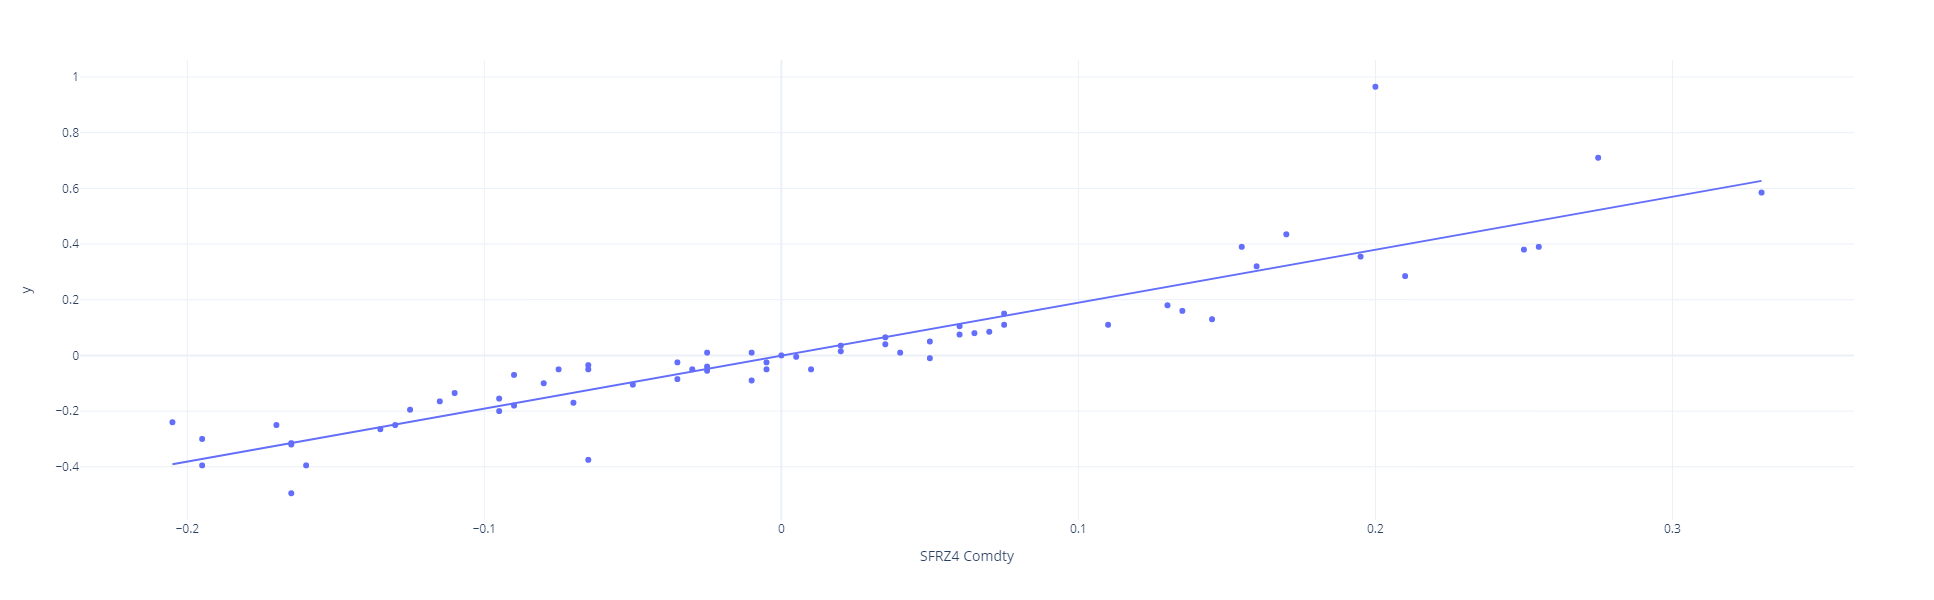

In [21]:
df_reg.plot.scatter(x='SFRZ4 Comdty', y='y', trendline="ols", height=600, template='plotly_white')

In [11]:
lm = LinearRegression(fit_intercept=False)
lm.fit(df_reg.iloc[:, :-1], df_reg.iloc[:, -1]);

In [12]:
y = df_reg.iloc[:, -1].rename('y')
y_pred = pd.Series(lm.predict(df_reg.iloc [:, :-1]), index=df_reg.iloc[:, :-1].index, name='pred')

In [13]:
c = lm.coef_[0]
r2 = lm.score(df_reg.iloc[:, :-1], df_reg.iloc[:, -1])
f"params: {lm.coef_}, intercept: {lm.intercept_}, r2: {r2}"

'params: [1.9021212], intercept: 0.0, r2: 0.8393111809680558'

In [ ]:
pd.concat([y, y_pred], axis=1).plot.scatter(x='y', y='pred', trendline="ols", height=500)

In [ ]:
df_plot = df_reg.cumsum()

In [ ]:
# df_plot['hedge'] = df_plot.iloc[:, :df_reg.shape[1] -1] @ + lm.coef_
df_plot['hedge'] = df_plot.iloc[:, :df_reg.shape[1] -1] @ + np.asanyarray([850, -600])

In [ ]:
df_plot

In [ ]:
df_plot.iloc[:, -2:].plot(height=700)

In [ ]:
df_plot.iloc[:, -2:].sum(axis=1).plot(height=700)

In [ ]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    trace1.data[0],
    secondary_y=False,
)

fig.add_trace(
    trace2.data[0],
    secondary_y=True,
)